In [1]:
%pylab inline
%load_ext autoreload

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.append('/home/students/s277665/.conda/envs/baseEnv/lib/python3.7/site-packages')
sys.path.append("/Users/francescoparino/Researchs/Mac2Mic/Util/")
sys.path.append("./")

In [3]:
import pandas as pd
import numpy as np
import scipy as spy
import os
import copy

import itertools
from glob import glob
import seaborn as sns
import matplotlib.patches as mpatches
from collections import Counter
from collections import defaultdict
from itertools import combinations

from multiprocessing import Pool
from functools import partial

from tqdm import tqdm_notebook

import collections, functools, operator 
from bidict import bidict
from sklearn.decomposition import NMF
from matplotlib.colors import LogNorm


from datetime import timedelta
import pickle
from sklearn.cluster import KMeans

blues = np.array(sns.light_palette("blue"))[[-4,-1]]
purples = np.array(sns.light_palette("purple"))[[-4,-1]]

In [4]:
SMALL_SIZE = 11
MEDIUM_SIZE = 11
BIGGER_SIZE = 11

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
twoColor = np.array(sns.hls_palette(8, l=.4, s=.9))[[1,2]]
from matplotlib import colors

def array2cmpa(X):
    X = np.c_[X,ones(len(X))]
    return colors.LinearSegmentedColormap.from_list('my_colormap', X)
twoColor = array2cmpa(twoColor)

coloMapMio = array2cmpa([(0.39471600258765605, 0.3011839071152027, 0.9088100597864414),
 (0.4776440582751795, 0.39692650086266157, 0.921303706524999),
 (0.5605721139627029, 0.4926690946101205, 0.9337973532635568),
 (0.6435001696502263, 0.5884116883575794, 0.9462910000021145),
 (0.7285014267299378, 0.6865478469487247, 0.9590969879091361),
 (0.8114294824174613, 0.7822904406961836, 0.9715906346476939),
 (0.8943575381049846, 0.8780330344436424, 0.9840842813862516),
 (0.95, 0.95, 0.95),
 (0.95, 0.95, 0.95),
 (0.8894900049789078, 0.9500428687418099, 0.8783502418622695),
 (0.7720924421399901, 0.8696585567920415, 0.754143441252265),
 (0.6546948793010723, 0.7892742448422732, 0.6299366406422604),
 (0.5343623773911816, 0.7068803250937606, 0.5026246700170056),
 (0.41696481455226386, 0.6264960131439923, 0.37841786940700106),
 (0.2995672517133462, 0.546111701194224, 0.2542110687969965),
 (0.18216968887442836, 0.4657273892444556, 0.13000426818699196)])

In [6]:
from Covid_Lib_Data import readCovidDataset, readMorti
from Covid_Lib_Simulator import parameters, initialStates, oneStep

In [7]:
cPre = "r"
cAlphaDec = "g"
cAlphaCos = "b"
cTrueNew = blues[0]
cPredNew = blues[1]
cTrueCum = purples[0]
cPredCum = purples[1]

mpPre      = mpatches.Patch(color=cPre, label='Pre Lockdown', alpha=0.2)
mpAlphaDec = mpatches.Patch(color=cAlphaDec, label='Lockdown Adaptation', alpha=0.2)

mpTrueNew  = matplotlib.lines.Line2D([0], [0],color=cTrueNew, label='Deaths (data)', alpha=1)
mpPredNew  = matplotlib.lines.Line2D([0], [0],color=cPredNew, label='Deaths (model)', alpha=1)

mpTrvlBn  = matplotlib.lines.Line2D([0], [0],color="black", label='Travel Ban', alpha=1)

In [8]:
dictProvincieNS, dictRegionNS, orderedPROV, convertPROV_REG, nh, Whk, covidProv, covidRegion, covidRegionCum, covidRegionNew = readCovidDataset()
cvdRgDc_CUM, cvdRgDc_NEW = readMorti()

preDay = 23 #effective 20gg before
pre = pd.DataFrame((np.zeros((preDay, 20))), columns = cvdRgDc_CUM.columns, index=pd.date_range(cvdRgDc_CUM.index[0]-datetime.timedelta(preDay), periods=preDay, freq='1D'))
pre.loc["2020-02-21", "Lombardia"] = 1
pre.loc["2020-02-22", "Lombardia"] = 1
pre.loc["2020-02-23", "Lombardia"] = 4
pre.loc["2020-02-20", "Veneto"] = 1
pre = pre.cumsum()

cvdRgDc_CUM = cvdRgDc_CUM.append(pre).sort_index()
cvdRgDc_NEW = cvdRgDc_CUM.diff()

<AxesSubplot:>

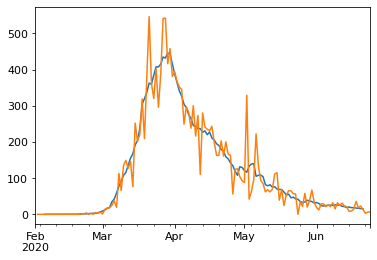

In [9]:
cvdRgDc_NEW["Lombardia"].rolling(7, center=True).mean().shift(0).dropna().plot(legend=False)
cvdRgDc_NEW["Lombardia"].plot(legend=False)

In [10]:
# Smooth
cvdRgDcRaw_NEW = cvdRgDc_NEW.copy().iloc[4:]
cvdRgDcRaw_CUM = cvdRgDc_CUM.copy().iloc[4:]
cvdRgDc_NEW = cvdRgDc_NEW.rolling(7, center=True).mean().dropna()
cvdRgDc_CUM = cvdRgDc_CUM.rolling(7, center=True).mean().dropna()

# Define Functions

In [11]:
def runTotal(SEINR, p, timeS=200, lockNord_b=None, lockSud_b=None, lockAll_alpha=None, smoothAlpha=True):
    S, E, I, N, R = SEINR
    
    time = np.arange(timeS)
    comSumForRegion = np.zeros((timeS, p.Whk.shape[0], 5))
    comSum = np.zeros((timeS, 5))
    rawSEINR = np.zeros((timeS, S.shape[0], p.Whk.shape[0], 5))
    
    
    # set and control alpha if negative
    if lockAll_alpha is not None:
        smoothDay = 15
        step = (1-p.alpha_lock)/smoothDay
        while lockAll_alpha < 0 and smoothDay>0: 
            print(f"Alpha Negative {lockAll_alpha}")
            lockAll_alpha += 1
            smoothDay -= 1
            p.alpha -= step
        
        
    # lockB negative
    if lockNord_b is not None:
        if lockNord_b < 0:  p.lockdown_b([dictProvincieNS[i] in {'Nord-ovest', 'Nord-est','Centro'} for i in orderedPROV])
    if lockSud_b is not None:
        if lockSud_b  < 0:  p.lockdown_b([dictProvincieNS[i] not in {'Nord-ovest', 'Nord-est','Centro'} for i in orderedPROV])
    

    for i in range(timeS):
        S, E, I, N, R = oneStep(SEINR,p) 
        
        rawSEINR[i] = np.dstack([S, E, I, N, R])
        comSumForRegion[i] = np.vstack([S.sum(0), E.sum(0), I.sum(0), N.sum(0), R.sum(0)]).transpose()
        comSum[i] = comSumForRegion[i].sum(0) #SEIAR
        SEINR = (S, E, I, N, R)
        
        if i == lockNord_b:
            p.lockdown_b([dictProvincieNS[i] in {'Nord-ovest', 'Nord-est','Centro'} for i in orderedPROV])
        if i == lockSud_b: 
            p.lockdown_b([dictProvincieNS[i] not in {'Nord-ovest', 'Nord-est','Centro'} for i in orderedPROV])
        
        
        if smoothAlpha:
            if i >= lockAll_alpha and i < (lockAll_alpha+smoothDay):
                p.alpha -= step
        else:
            if i == lockAll_alpha:
                p.lockdown_alpha()
            
    return time, comSum, comSumForRegion, rawSEINR



def getDataset(startDate, ggFit, initialEI_pos=-1, regionS=None):
    
    cvdRgDc_NEW_FIT = cvdRgDc_NEW[startDate: startDate + datetime.timedelta(days=ggFit)]
    cvdRgDc_CUM_FIT = cvdRgDc_CUM[startDate: startDate + datetime.timedelta(days=ggFit)]
    
    #Filter Regions
    if not regionS is None:
        cvdRgDc_CUM_FIT = cvdRgDc_CUM_FIT.loc[:, regionS]
        cvdRgDc_NEW_FIT = cvdRgDc_NEW_FIT.loc[:, regionS]
        
    #compute initial E,I
    initialCaseI = covidProv.iloc[initialEI_pos].values
    initialCaseE = covidProv.iloc[initialEI_pos].values
    
    realData = (cvdRgDc_CUM_FIT, cvdRgDc_NEW_FIT, initialCaseI, initialCaseE)
    return realData



def fToMin(inp, realData, dateLocks, ggFit, provinceLevel=False):
    #init
    cvdRgDc_CUM_FIT, cvdRgDc_NEW_FIT, initialCaseI, initialCaseE = realData
    Lambda, alpha_lock, b_lock, precentageE, precentageI = inp
    lockNord_b, lockSud_b, lockAll_alpha = dateLocks
    
    p = parameters(nh, Whk, Lambda=Lambda, alpha_lock=alpha_lock, b_lock=b_lock, precentageE=precentageE, precentageI=precentageI)
    
    
    SEINR = initialStates(p, initialCaseI, initialCaseE)

    #run
    time, comSum, comSumForRegion, rawSEINR = runTotal(SEINR, p, ggFit+1, lockNord_b, lockSud_b, lockAll_alpha)
    
    # crete timeseries from results
    mdlI = pd.DataFrame(comSumForRegion[:, :, 2], columns=orderedPROV)
    mdlI.index = pd.date_range(mdlI.index[0], periods=len(mdlI), freq='1D') 
    
    mdlDc_CUM = pd.DataFrame((rawSEINR[:, :, :, 4] * p.mortality.reshape(1, 2, 1)).sum(1), columns=orderedPROV)
    mdlDc_CUM.index = pd.date_range(cvdRgDc_CUM_FIT.index[0], periods=len(mdlDc_CUM), freq='1D')     
    
    if provinceLevel:
        return mdlI, mdlDc_CUM
    
    # rename axix to match dataset
    mdlI.columns = [convertPROV_REG[i] for i in mdlI.columns]
    mdlI = mdlI.groupby(level=0, axis=1).sum()
    
    mdlDc_CUM.columns = [convertPROV_REG[i] for i in mdlDc_CUM.columns]
    mdlDc_CUM = mdlDc_CUM.groupby(level=0, axis=1).sum()
    
    return mdlI, mdlDc_CUM

# RUN EXPERIMENTS

In [12]:
# Time Period Fit
initialEI_pos_BEST = -1
startDate = cvdRgDc_CUM.index[0]
ggFit_BEST = list(cvdRgDc_CUM.index).index(cvdRgDc_CUM.loc["2020-05-18"].name)

# Lock-down strategies
lockNord_b_BEST = (datetime.datetime(2020, 3, 1) - startDate).days
lockSud_b_BEST = (datetime.datetime(2020, 3, 7) - startDate).days
lockAll_alpha_BEST = (datetime.datetime(2020, 3, 5) - startDate).days

In [13]:
{'Lambda': 0.04218151748264074, 'alpha_lock': 0.17657372198907198, 'b_lock': 0.0, 'initialE': -3.6060057687708658, 'initialI': -2.1024724516951636}

{'Lambda': 0.04218151748264074,
 'alpha_lock': 0.17657372198907198,
 'b_lock': 0.0,
 'initialE': -3.6060057687708658,
 'initialI': -2.1024724516951636}

In [14]:
GG_EXP = (datetime.datetime(2020, 5, 18) - startDate).days
GG_EXP

104

In [15]:
B_LOW_BEST = 0
ALPHA_LOW_BEST = 0.17657372198907198

Lambda = 0.04218151748264074
initialE = -3.6060057687708658
initialI = -2.1024724516951636

In [16]:
def getExperiment(lockNord_b, lockSud_b, lockAll_alpha, alpha_low, b_low, ggFit=ggFit_BEST, provinceLevel=False):
    par = [Lambda,  alpha_low,  b_low, initialE, initialI]
    realData = getDataset(startDate, ggFit, initialEI_pos_BEST)
    dateLocks = lockNord_b, lockSud_b, lockAll_alpha
    
    mdlI, mdlDc_CUM = fToMin(par, realData, dateLocks, ggFit, provinceLevel=provinceLevel)
    return mdlI, mdlDc_CUM

In [17]:
lockAll_alpha_R = (datetime.datetime(2020, 3, 5) - startDate).days
lockAll_alpha_B = lockAll_alpha_R - 15
lockAll_alpha_BB = lockAll_alpha_R - 26
lockAll_alpha_A = lockAll_alpha_R + 15

lock_b_R = (datetime.datetime(2020, 3, 1) - startDate).days
lock_b_B = lock_b_R - 15
lock_b_BB = lock_b_R - 26
lock_b_A = lock_b_R + 15

# Surfaces ***Prevalence***

In [18]:
MIN_ALPHA = ALPHA_LOW_BEST - ALPHA_LOW_BEST*0.5
MAX_ALPHA = ALPHA_LOW_BEST + ALPHA_LOW_BEST*0.5

In [19]:
SAVEFIG_FOLDER = "./close_complete_PREV_104_5050"
if not os.path.exists(SAVEFIG_FOLDER): os.makedirs(SAVEFIG_FOLDER)
    
def getPrevalenceMax(alpha_low, b_low, lockNord_b, lockSud_b, lockAll_alpha, provinceLevel=False):
    ggFit = GG_EXP 
    
    mdlI, mdlDc_CUM = getExperiment(lockNord_b, lockSud_b, lockAll_alpha, alpha_low, b_low, ggFit=ggFit, provinceLevel=provinceLevel)
    
    
    #return alpha_low, b_low, mdlI.max()
    return alpha_low, b_low,  mdlDc_CUM.max()

In [20]:
def getExpPrevalence(lock_alpha, lock_b):
    # creade grid exp
    
    alphaLowGrid = np.linspace(MIN_ALPHA, MAX_ALPHA, 20)
    bLowGrid = np.linspace(0, 1, 20)

    gird = itertools.product(alphaLowGrid, bLowGrid)
    with Pool(12) as pool:
        f = partial(getPrevalenceMax, lockNord_b=lock_b, lockSud_b=lock_b, lockAll_alpha=lock_alpha, provinceLevel=True)
        res = pool.starmap(f, gird)
    
    # diff respect to real lockdown
    _,_,real = getPrevalenceMax(ALPHA_LOW_BEST, B_LOW_BEST, lock_b, lock_b, lock_alpha, provinceLevel=True)
    resNrm1 = [(i,j,k/real) for i,j,k in res]
    
    return res, resNrm1, alphaLowGrid, bLowGrid


def getLogColor(data, vmin=None, vmax=None): 
    if vmin is None: vmin=data.min().min()
    if vmax is None: vmax=data.max().max()
    
    log_norm = LogNorm(vmin=vmin, vmax=vmax)
    #cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(data.min().min())), math.ceil(math.log10(data.max().max())))]
    cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(vmin)), math.ceil(math.log10(vmax)))]
    
    return log_norm, cbar_ticks

In [92]:
from matplotlib import ticker
def plotExmpl(res, save=None, examp=["Milano"], suptitle="", cRed=False, applyLog=False):
    #fig, axs = plt.subplots(2, int(ceil(len(examp)/2)), sharex=False, sharey=False, figsize=(int(ceil(len(examp)/2))*3.5,6))
    fig, axs = plt.subplots(2, int(ceil(len(examp)/2)), sharex=False, sharey=False, figsize=(3,7))
    for _examp,ax in zip(examp, np.ravel(axs)):
        resTot = pd.DataFrame([(i, j, k[_examp]) for i,j,k in res], columns=["alpha_low", "b_low", "prevalence"]).set_index(["alpha_low", "b_low"]).unstack().droplevel(0, 1)
        resTot.sort_index(ascending=False, inplace=True)
        resTot.index = [f"{i:.3f}" for i in resTot.index]
        resTot.columns = [f"{i:.3f}" for i in resTot.columns]
        
        cmap = sns.cubehelix_palette(8, start=0, rot=-.8, gamma = .8, hue=1, light=1, as_cmap=True)
        log_norm, cbar_ticks = getLogColor(resTot)
        
        mapp = ax.imshow(resTot, interpolation="bilinear", cmap=cmap,  extent=[0,1, MIN_ALPHA,MAX_ALPHA], aspect = 1/(MAX_ALPHA-MIN_ALPHA))
        #mapp = ax.imshow(resTot, interpolation="bilinear", cmap=cmap, norm=log_norm,  extent=[0,1, MIN_ALPHA,MAX_ALPHA], aspect = 1/(MAX_ALPHA-MIN_ALPHA))
        cb = fig.colorbar(mapp, ax=ax, fraction=0.04, pad=0.04)
        cb.outline.set_visible(False)
        cb.ax.yaxis.set_major_locator(ticker.MaxNLocator(5, integer=True))
        
        
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.set_xlabel(f"$\\beta$")
        ax.set_ylabel(f"$\\alpha$")
        ax.set_title(_examp, size=12)

    plt.suptitle(suptitle, y = .97, size=12)
    #plt.tight_layout()
    
    
    if save is not None:
        plt.savefig(f"./{SAVEFIG_FOLDER}/{save}.pdf", bbox_inches = "tight")

### Definition Tensor decomposition

In [51]:
def doMNF(tensor, nComp = 2):
    shapeOrign = tensor.shape 
    tensorVec = tensor.reshape(tensor.shape[0], tensor.shape[1]*tensor.shape[2])
    
    mdoelNMF = NMF(n_components=nComp)
    coeff = mdoelNMF.fit_transform(tensorVec)
    basis = mdoelNMF.components_.reshape(nComp, shapeOrign[1], shapeOrign[2])
    
    return coeff, basis

def getExpTensor(res, nComp=2):
    tensor = list()
    for _region in res[0][-1].index:
        matrixReg = pd.DataFrame([(i, j, k[_region]) for i,j,k in res], columns=["alpha_low", "b_low", "prevalence"]).set_index(["alpha_low", "b_low"]).unstack()
        
        matrixReg = matrixReg.values
        #matrixReg = (((matrixReg - matrixReg.min())/(matrixReg.max() - matrixReg.min())) * 100) + 1
        #matrixReg = np.log10(matrixReg)
        matrixReg = (matrixReg - matrixReg.min())/(matrixReg.max() - matrixReg.min())
        
        tensor.append(matrixReg)

    tensor = np.array(tensor)
    coeff, basis = doMNF(tensor, nComp = nComp)
    return coeff, basis

In [52]:
from adjustText import adjust_text

def plotDecomposition(res, pltRgName=False, pltScatter=False, examp=["Milano"], save=None, suptitle="", revColor=False):
    coeff, basis = getExpTensor(res)
    
    fig, axs = plt.subplots(1, basis.shape[0], sharex=False, sharey=False, figsize=(9, 3))
    n = 0
    
    vmax = 0
    vmin = 1e8
    for _basis in basis:
        vmax = max((vmax, _basis.max()))
        vmin = min((vmin, _basis.min()))
        
    
    for _basis,ax in zip(basis, np.ravel(axs)):
        resTot = pd.DataFrame(_basis, index = alphaLowGrid, columns=bLowGrid)
        resTot.sort_index(ascending=False, inplace=True)
        resTot.index = [f"{i:.3f}" for i in resTot.index]
        resTot.columns = [f"{i:.3f}" for i in resTot.columns]
        
        cmap = sns.cubehelix_palette(8, start=0, rot=-.8, gamma = .8, hue=1, light=1, as_cmap=True)
        mapp = ax.imshow(resTot, interpolation="bilinear", cmap=cmap,  extent=[0,1, MIN_ALPHA,MAX_ALPHA], aspect = 1/(MAX_ALPHA-MIN_ALPHA))
        fig.colorbar(mapp, ax=ax, fraction=0.04, pad=0.04).outline.set_visible(False)
        
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.set_xlabel(f"$\\beta$")
        ax.set_ylabel(f"$\\alpha$")
        ax.set_title(f"Component {n}")
        n += 1
    
    plt.suptitle(suptitle, y=1.1)
    #plt.tight_layout()
    
    if save is not None: plt.savefig(f"./{SAVEFIG_FOLDER}/{save}_components.pdf", bbox_inches = "tight")
    
    if pltRgName:
        fig, axs = plt.subplots(figsize=(8, 4))
        plt.scatter(coeff[:,0], coeff[:,1])
        texts = list()
        for x,y,t in (zip(coeff[:,0], coeff[:,1], res[0][-1].index)):

            texts.append(plt.text(x, y, t, ha='center', va='center'))
        adjust_text(texts, lim=10) 
        if save is not None: plt.savefig(f"./{SAVEFIG_FOLDER}/{save}_scatterText.pdf", bbox_inches = "tight")
    
    
    if pltScatter:
        fig, axs = plt.subplots(figsize=(5, 3))
        kmeans = KMeans(n_clusters=2, random_state=0).fit(coeff)
        
        
        texts = list()
        edgecolors = list()
        label = ["Unaffected by \nsmobility \nrestrictions" , "Affected by \nmobility \nrestrictions"]
        
        for x,y,t in (zip(coeff[:,0], coeff[:,1], res[0][-1].index)):
            if t in examp:
                edgecolors.append("black")
                texts.append(plt.text(x, y, t, ha='center', va='center'))
            else:
                edgecolors.append("w")
                
        if revColor: 
            cmap=twoColor.reversed()
            label = list(reversed(label))
        else: 
            cmap=twoColor
            
            
        scatter = plt.scatter(coeff[:,0], coeff[:,1], s=50, c=kmeans.labels_, cmap=cmap, edgecolors=edgecolors, label=label)    
        plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],c = "r", marker="x", label="Cluster center")
        plt.legend(handles=scatter.legend_elements()[0], labels=label)
        
        
        adjust_text(texts, lim=20) 
        plt.xlabel("Component 0")
        plt.ylabel("Component 1")
  
        if save is not None: 
            plt.savefig(f"./{SAVEFIG_FOLDER}/{save}_cluster.pdf", bbox_inches = "tight")
            pickle.dump(list(zip(res[0][-1].index, kmeans.labels_)), open(f"./{SAVEFIG_FOLDER}/{save}_clusterToProvince.p", "wb" ))    
        
        
    return coeff, basis

In [53]:
def aggregateAtMacro(res):
    _res = list()
    for i,j,k in res:
        k = k.copy()
        k.index = [dictProvincieNS[i] for i in k.index]
        k = k.groupby(level=0).sum()
        _res.append((i,j,k))
    return _res

In [54]:
def aggregateRegion(res):
    _res = list()
    for i,j,k in res:
        k = k.copy()
        k.index = [convertPROV_REG[i] for i in k.index]
        k = k.groupby(level=0).sum()
        _res.append((i,j,k))
    return _res

### run

In [94]:
%%capture

allExp = (
(lock_b_BB, lockAll_alpha_BB, "BB_BB"),
(lock_b_BB, lockAll_alpha_B, "BB_B"),
(lock_b_BB, lockAll_alpha_R, "BB_R"),
(lock_b_B, lockAll_alpha_B, "B_B"),
(lock_b_B, lockAll_alpha_R, "B_R"),
(lock_b_R, lockAll_alpha_R, "R_R"),
(lock_b_A, lockAll_alpha_A, "A_A"),
(lock_b_A, lockAll_alpha_A, "R_A"))

allExp = ((lock_b_BB, lockAll_alpha_B, "BB_B"),
(lock_b_B, lockAll_alpha_B, "B_B"),
(lock_b_R, lockAll_alpha_R, "R_R"))


for bet, alp, nam in allExp:
    

    dateBeta = bet
    dateAlpha = alp
    saveName = "province_" + nam


    dateBLow = (startDate + timedelta(dateBeta)).strftime("%B %-d")
    dateAlphaLow = (startDate + timedelta(dateAlpha)).strftime("%B %-d")
    suptitle=f"Mobility restrictions on {dateBLow} \nActivity reduction on {dateAlphaLow}"

    examp = ["Sud Sardegna", "Bergamo"]
    res, resNrm1, alphaLowGrid, bLowGrid = getExpPrevalence(dateAlpha, dateBeta)
    plotExmpl(res,examp=examp, suptitle=suptitle, save=saveName, applyLog=True)
    
    examp = ["Sud Sardegna", "Varese", "Bergamo", "Monza e della Brianza"]
    coeff, basis = plotDecomposition(res, True, True, examp=examp, suptitle=suptitle, save=saveName, revColor=True)

In [97]:
dateBeta = lock_b_BB
dateAlpha = lockAll_alpha_B
saveName = "province_BB_B"

dateBLow = (startDate + timedelta(dateBeta)).strftime("%B %-d")
dateAlphaLow = (startDate + timedelta(dateAlpha)).strftime("%B %-d")
suptitle=f"Mobility restrictions on {dateBLow} \nActivity reduction on {dateAlphaLow}"

res, resNrm1, alphaLowGrid, bLowGrid = getExpPrevalence(dateAlpha, dateBeta)

/opt/anaconda3/envs/bigdatalab/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1077: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  " improve convergence." % max_iter, ConvergenceWarning)


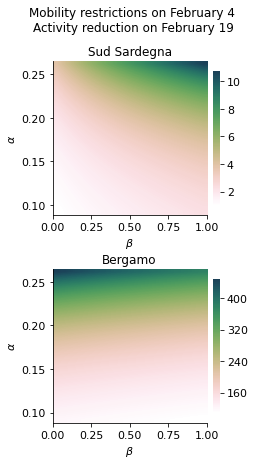

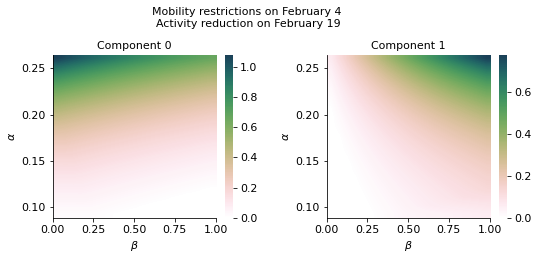

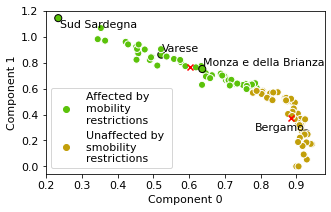

In [99]:
examp = ["Sud Sardegna", "Bergamo"]
plotExmpl(res,examp=examp, suptitle=suptitle, save=saveName, applyLog=True)

examp = ["Sud Sardegna", "Varese", "Bergamo", "Monza e della Brianza"]
coeff, basis = plotDecomposition(res, False, True, examp=examp, suptitle=suptitle, save=saveName, revColor=True)

# OverallItaly

In [27]:
examp = ["Palermo", "Sud Sardegna", "Taranto", "Brescia", "Bergamo", "Lodi"]

dateBeta = lock_b_B
dateAlpha = lockAll_alpha_R
saveName = "province_B_R"

dateBLow = (startDate + timedelta(dateBeta)).strftime("%B %-d")
dateAlphaLow = (startDate + timedelta(dateAlpha)).strftime("%B %-d")
suptitle=f"Mobility restriction on {dateBLow} \nActivity reduction on {dateAlphaLow}"

res, resNrm1, alphaLowGrid, bLowGrid = getExpPrevalence(dateAlpha, dateBeta)
res = [(i,j,pd.Series(k.sum(0), index=["Italy"])) for i,j,k in res]

In [31]:
def plotExmpl(res, save=None, examp=["Italy"], suptitle="", cRed=False, applyLog=False):
    fig, axs = plt.subplots(1, 1, sharex=False, sharey=True, figsize=(5, 4))
    for _examp,ax in zip(examp, np.ravel(axs)):
        resTot = pd.DataFrame([(i, j, k[_examp]) for i,j,k in res], columns=["alpha_low", "b_low", "prevalence"]).set_index(["alpha_low", "b_low"]).unstack().droplevel(0, 1)
        resTot.sort_index(ascending=False, inplace=True)
        #resTot.index = [f"{i:.2f}" for i in resTot.index]
        #resTot.columns = [f"{i:.2f}" for i in resTot.columns]
        
        #resTot = resTot.divide(resTot.iloc[:, -1], axis=0) - 1 
        cmap = sns.cubehelix_palette(8, start=0, rot=-.8, gamma = .8, hue=1, light=1, as_cmap=True)
        log_norm, cbar_ticks = getLogColor(resTot)
        plt.imshow(resTot, interpolation="bilinear", cmap=cmap, norm=log_norm, extent=[0,1, MIN_ALPHA,MAX_ALPHA], aspect = 1/(MAX_ALPHA-MIN_ALPHA))
        cb = plt.colorbar(label=f"Number of deaths").outline.set_visible(False)
        
        ax.set_xlabel(f"$\\beta$")
        ax.set_ylabel(f"$\\alpha$")
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        #ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
        

        maxInd = resTot.index[np.unravel_index(resTot.values.argmax(), resTot.values.shape)[0]]
        maxCol = resTot.columns[np.unravel_index(resTot.values.argmax(), resTot.values.shape)[1]]
        maxVal = resTot.values.max()

        print(f"max value at {maxInd, maxCol}, {maxVal}")

    #plt.suptitle(suptitle, y = 1.05, fontsize=12)
    #plt.tight_layout()
    
    
    #matplotlib2tikz.save(f"./{SAVEFIG_FOLDER}/{save}_Italy.tex")
    plt.savefig(f"./{SAVEFIG_FOLDER}/{save}_Italy.pdf", bbox_inches = "tight")

max value at (0.26384684318199103, 1.0), 88753.016891953


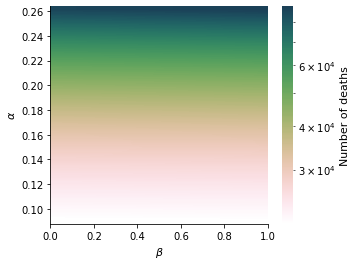

In [32]:
plotExmpl(res, suptitle=suptitle, save=saveName, applyLog=True)